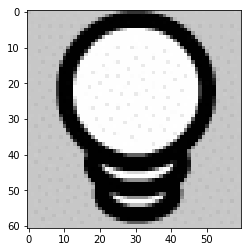

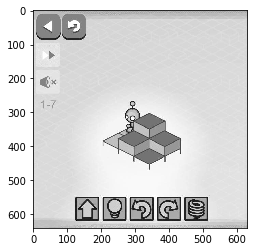

img1 - 13 features, img2 - 607 features
7 / 7  inliers/matched


In [3]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

def filter_matches(kp1, kp2, matches, ratio = 0.75):
    mkp1, mkp2 = [], []
    for m in matches:
        if len(m) == 2 and m[0].distance < m[1].distance * ratio:
            m = m[0]
            mkp1.append( kp1[m.queryIdx] )
            mkp2.append( kp2[m.trainIdx] )
    p1 = np.float32([kp.pt for kp in mkp1])
    p2 = np.float32([kp.pt for kp in mkp2])
    kp_pairs = zip(mkp1, mkp2)
    return p1, p2, list(kp_pairs)

img1 = cv2.imread("icones/lamp.jpg", 0)
plt.imshow(img1,cmap = 'gray')
plt.show()

img2 = cv2.imread("virtual_imgs/1.jpg", 0)
plt.imshow(img2,cmap = 'gray')
plt.show()
detector = cv2.xfeatures2d.SIFT_create()
norm = cv2.NORM_L2
matcher = cv2.BFMatcher(norm)

kp1, desc1 = detector.detectAndCompute(img1, None)
kp2, desc2 = detector.detectAndCompute(img2, None)
print('img1 - %d features, img2 - %d features' % (len(kp1), len(kp2)))

raw_matches = matcher.knnMatch(desc1, trainDescriptors = desc2, k = 2) #2
p1, p2, kp_pairs = filter_matches(kp1, kp2, raw_matches)
if len(p1) >= 4:
    H, status = cv2.findHomography(p1, p2, cv2.RANSAC, 5.0)
    print('%d / %d  inliers/matched' % (np.sum(status), len(status)))
else:
    H, status = None, None
    print('%d matches found, not enough for homography estimation' % len(p1))



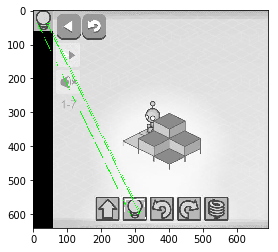

In [20]:
h1, w1 = img1.shape[:2]
h2, w2 = img2.shape[:2]
vis = np.zeros((max(h1, h2), w1+w2), np.uint8)
vis[:h1, :w1] = img1
vis[:h2, w1:w1+w2] = img2
vis = cv2.cvtColor(vis, cv2.COLOR_GRAY2BGR)

if H is not None:
    corners = np.float32([[0, 0], [w1, 0], [w1, h1], [0, h1]])
    corners = np.int32( cv2.perspectiveTransform(corners.reshape(1, -1, 2), H).reshape(-1, 2) + (w1, 0) )
    cv2.polylines(vis, [corners], True, (255, 255, 255))

if status is None:
    status = np.ones(len(kp_pairs), np.bool_)
p1, p2 = [], []  # python 2 / python 3 change of zip unpacking
for kpp in kp_pairs:
    p1.append(np.int32(kpp[0].pt))
    p2.append(np.int32(np.array(kpp[1].pt) + [w1, 0]))

green = (0, 255, 0)
red = (0, 0, 255)
kp_color = (51, 103, 236)
for (x1, y1), (x2, y2), inlier in zip(p1, p2, status):
    if inlier:
        col = green
        cv2.circle(vis, (x1, y1), 2, col, -1)
        cv2.circle(vis, (x2, y2), 2, col, -1)
    else:
        col = red
        r = 2
        thickness = 3
        cv2.line(vis, (x1-r, y1-r), (x1+r, y1+r), col, thickness)
        cv2.line(vis, (x1-r, y1+r), (x1+r, y1-r), col, thickness)
        cv2.line(vis, (x2-r, y2-r), (x2+r, y2+r), col, thickness)
        cv2.line(vis, (x2-r, y2+r), (x2+r, y2-r), col, thickness)
vis0 = vis.copy()
for (x1, y1), (x2, y2), inlier in zip(p1, p2, status):
    if inlier:
        cv2.line(vis, (x1, y1), (x2, y2), green)
        
plt.imshow(vis)
plt.show()